In [1]:
import pandas as pd
sun=pd.read_csv("C:/Users/HOME/Downloads/sunspots_month.csv")
sun.head()

,Year,Value
0,1749-01-01,58.0
1,1749-02-01,62.6
2,1749-03-01,70.0
3,1749-04-01,55.7
4,1749-05-01,85.0


In [2]:
#Specifying the dates
sun.Year=pd.to_datetime(sun.Year, format='%Y-%m-%d')
sun.set_index('Year', inplace=True)
sun.head()


,Value
Year,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0


In [7]:
#Resampling to Yearly Frequency
sun_year = sun.resample('YE').mean()


In [8]:
#sun_year

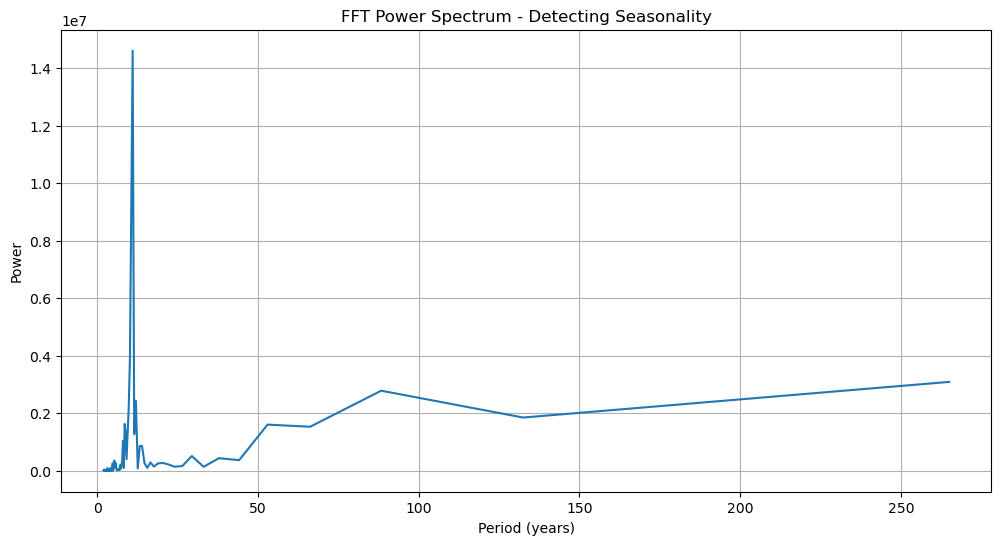

In [9]:
import numpy as np
data = sun_year['Value'].values  # convert to NumPy array for FFT


# FFT
from scipy import fftpack
Y = fftpack.fft(data)
n = len(Y) // 2

# Frequencies
freq = fftpack.fftfreq(len(Y))[:n]

# Power spectrum
power = np.abs(Y[:n])**2

# Periods
period = np.zeros_like(freq)
nonzero = freq != 0
period[nonzero] = 1 / freq[nonzero]

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(period[1:], power[1:])
plt.xlabel('Period (years)')
plt.ylabel('Power')
plt.title('FFT Power Spectrum - Detecting Seasonality')
plt.grid(True)
plt.show()

**Rolling Statistics**

In [10]:
rolling_mean = sun_year['Value'].rolling (2).mean()
rolling_std = sun_year['Value'].rolling (2).std()


In [11]:
rolling_mean

Year
1749-12-31          NaN
1750-12-31    82.158333
1751-12-31    65.525000
1752-12-31    47.729167
1753-12-31    39.237500
                ...    
2009-12-31     2.983333
2010-12-31     9.800000
2011-12-31    36.054167
2012-12-31    56.595833
2013-12-31    57.819444
Freq: YE-DEC, Name: Value, Length: 265, dtype: float64

**Using Dickey-Fuller test**

In [12]:
from statsmodels.tsa.stattools import adfuller
df_test = adfuller(sun_year['Value'], autolag='AIC')

In [13]:
def is_stationary(df_test):
    stationary=[]
    
    print(f'Test Statistic: {df_test[0]}')
    print(f'P_value: {df_test[1]}')
    print(f' No. of lags Used: {df_test[2]}')
    print(f' No. of Observations: {df_test[3]}')

    for key, value in df_test[4].items():
        print(f'Critical Value ({key}): {value}')
        if df_test[0] <= value:
            stationary.append(True)
        else:
            stationary.append(False)
            
    return all (stationary)
            

In [14]:
is_stationary(df_test)

Test Statistic: -2.470847286836293
P_value: 0.12272956184228728
 No. of lags Used: 8
 No. of Observations: 256
Critical Value (1%): -3.4561550092339512
Critical Value (5%): -2.8728972266578676
Critical Value (10%): -2.5728222369384763


False

**Decomposition**

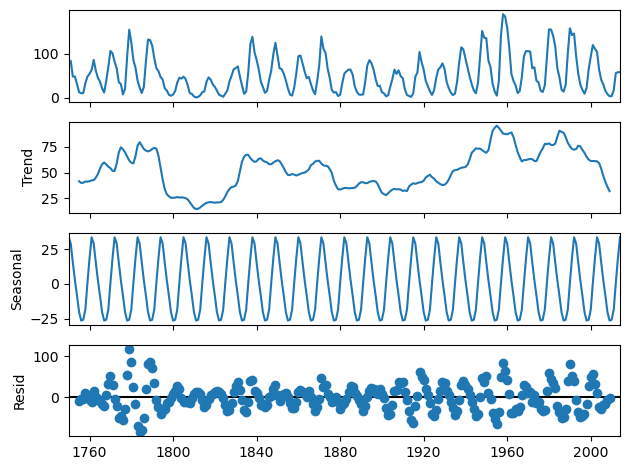

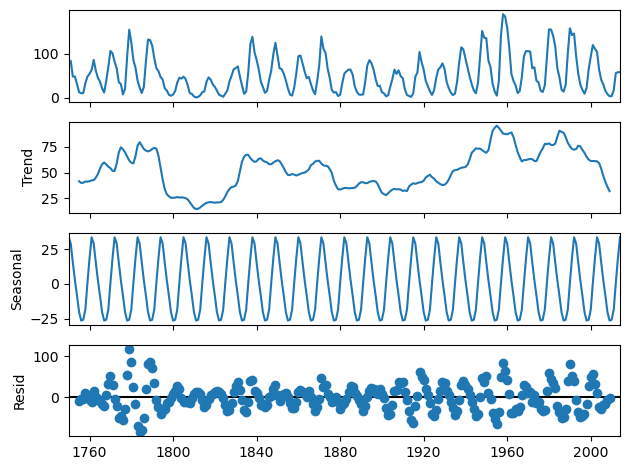

In [15]:
import statsmodels.api as sm
dec_sunspots = sm.tsa.seasonal_decompose(sun_year, model='additive', period=11)

dec_sunspots.plot()

In [16]:
#checking each component
print(dec_sunspots.trend)
print(dec_sunspots.seasonal)
print(dec_sunspots.resid)

Year
1749-12-31   NaN
1750-12-31   NaN
1751-12-31   NaN
1752-12-31   NaN
1753-12-31   NaN
              ..
2009-12-31   NaN
2010-12-31   NaN
2011-12-31   NaN
2012-12-31   NaN
2013-12-31   NaN
Freq: YE-DEC, Name: trend, Length: 265, dtype: float64
Year
1749-12-31    33.522025
1750-12-31    28.962275
1751-12-31    15.396465
1752-12-31     2.597816
1753-12-31    -8.491447
                ...    
2009-12-31   -25.805412
2010-12-31   -18.484134
2011-12-31     0.645049
2012-12-31    18.410628
2013-12-31    33.522025
Freq: YE-DEC, Name: seasonal, Length: 265, dtype: float64
Year
1749-12-31   NaN
1750-12-31   NaN
1751-12-31   NaN
1752-12-31   NaN
1753-12-31   NaN
              ..
2009-12-31   NaN
2010-12-31   NaN
2011-12-31   NaN
2012-12-31   NaN
2013-12-31   NaN
Freq: YE-DEC, Name: resid, Length: 265, dtype: float64


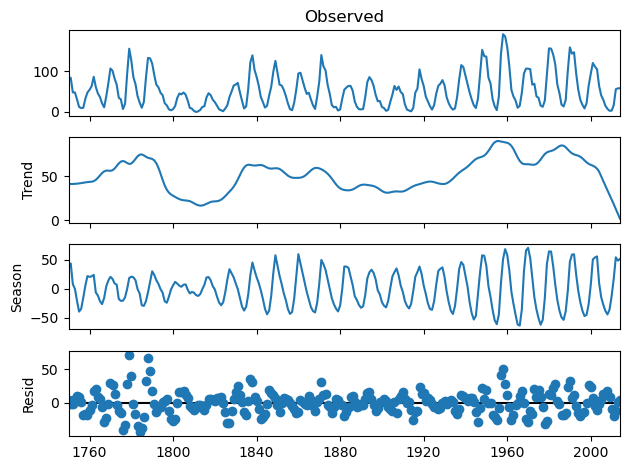

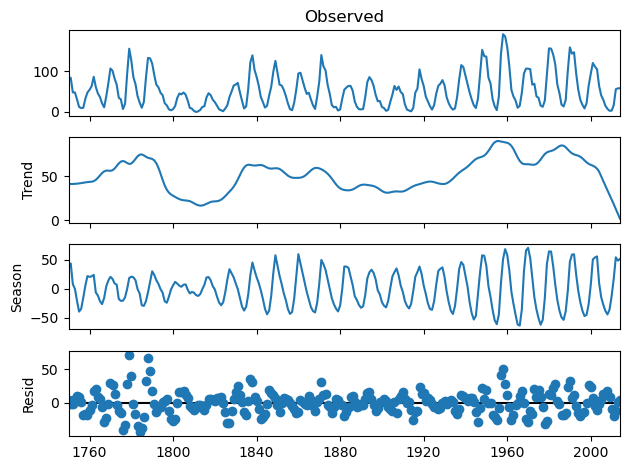

In [17]:
from statsmodels.tsa.seasonal import STL

stl= STL(sun_year, period=11)
res =stl.fit()
res.plot()

In [19]:
sun_year.shape

(265, 1)

***Autocorrelation***

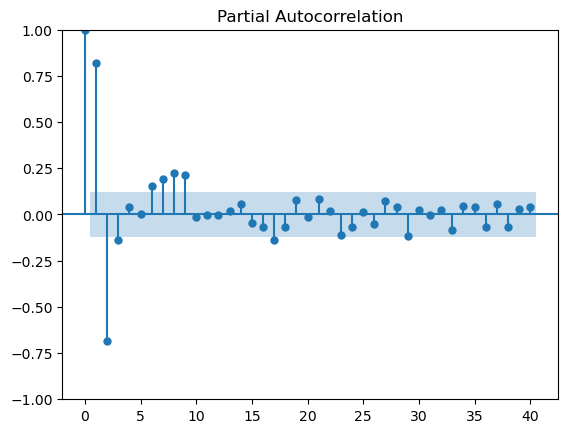

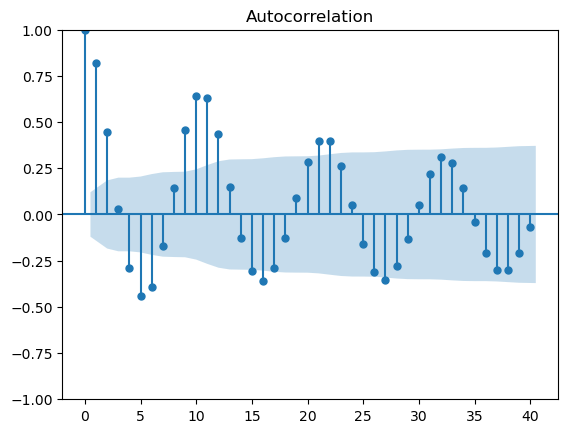

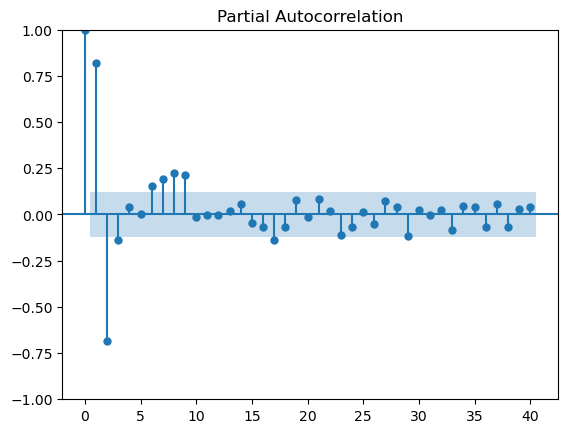

In [20]:
sm.graphics.tsa.plot_acf(sun_year, lags=40)
sm.graphics.tsa.plot_pacf(sun_year, lags=40)

***ARMA AND ARIMA***

In [44]:
from statsmodels.tsa.arima.model import ARIMA
arma_sun = ARIMA(sun_year, order=(9,1,0)).fit()
print(arma_sun.params)

ar.L1       0.193435
ar.L2      -0.193816
ar.L3      -0.363354
ar.L4      -0.198525
ar.L5      -0.285872
ar.L6      -0.234372
ar.L7      -0.207221
ar.L8      -0.257723
ar.L9      -0.009971
sigma2    247.001312
dtype: float64


In [29]:
print("AIC:", arma_sun.aic)
print("BIC:", arma_sun.bic)
print("HQIC:", arma_sun.hqic)

AIC: 2230.4154820820295
BIC: 2269.792510167878
HQIC: 2246.236569934687


***Searching for the best model***

In [38]:
#differencing 
sun_year.diff().dropna()

,Value
Year,
1750-12-31,2.466667
1751-12-31,-35.733333
1752-12-31,0.141667
1753-12-31,-17.125000
1754-12-31,-18.458333
...,...
2009-12-31,0.233333
2010-12-31,13.400000
2011-12-31,39.108333


In [55]:
predict_sunspots= arma_sun.predict('2001','2050', dynamic=True)

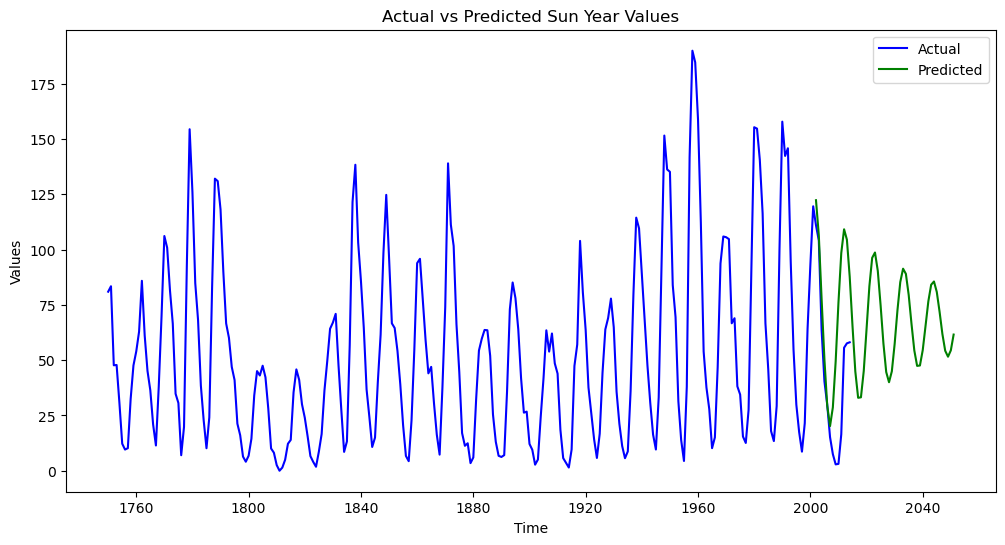

In [56]:
plt.figure(figsize=(12,6))
plt.plot(sun_year, label="Actual", color='blue')
plt.plot(predict_sunspots, label="Predicted", color='green')
plt.title('Actual vs Predicted Sun Year Values')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()